# Cellular automata + Regression #

Inspired by professor's game of life and forest fire ipynb

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse

print("Numpy version {}".format(np.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt # Core plotting support
print("Matplotlib version {}".format(mpl.__version__))

Numpy version 1.17.3
Matplotlib version 3.3.1


## Setup

These first few cells walk through the core building blocks of the simulation:

* `create_world(n, q)`: Returns a new "world" of size `(n+2)`-by-`(n+2)`, where the probability that any cell initially contains a living tree is `q`. The extra padding on the boundaries is initialized to "empty" (0 values), and is there to simplify some of the subsequent array indexing and slicing.

* `show_world(W)`: Creates a "heat map" of the current world. The assumed states of each cell are "dead" (0) and "alive" (1).

The world is 50 x 50 in size (excluding padded boundaries).
The city is 20 x 20 in size (excluding padded boundaries).
In the world, 247 cells are alive, the remaining 2253 are not.
In the city boundaries, 41 cells are alive
The world is 18 x 18 in size (excluding padded boundaries).
The city is 20 x 20 in size (excluding padded boundaries).
In the world, 68 cells are alive, the remaining 256 are not.
In the city boundaries, 0 cells are alive
The world is 50 x 50 in size (excluding padded boundaries).
The city is 20 x 20 in size (excluding padded boundaries).
In the world, 274 cells are alive, the remaining 2226 are not.
In the city boundaries, 68 cells are alive


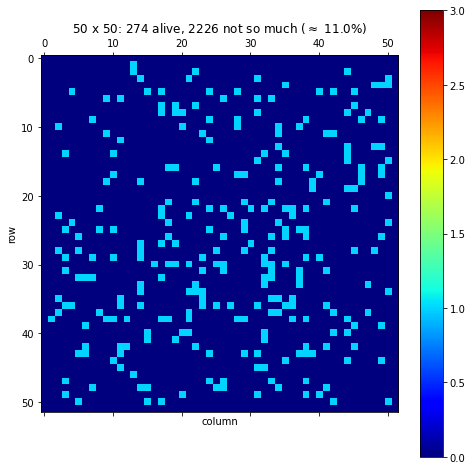

In [2]:
def empty_world(x, n=None):
    from numpy import ndarray
    if isinstance(x, ndarray):
        return np.zeros(x.shape)
    m = x
    if n is None:
        n = m
    return np.zeros((m+2, n+2))

def interior(W, dx=0, dy=0):
    m, n = W.shape
    return W[(1+dy):(m-1+dy), (1+dx):(n-1+dx)]

def get_city(W):
    return W[20:40, 20:40]
    
def create_world(n, q):
    World = empty_world(n)
    Interior = interior(World)
    Interior[:, :] = np.random.choice([0, 1], p=[1-q, q], size=(n, n))
    return World

def is_dead(W):
    return W == 0

def is_alive(W):
    return W == 1

def count(W, cond_fun):
    return cond_fun(W).sum()

def summarize_world(W):
    m, n = W.shape[0]-2, W.shape[1]-2
    n_alive = count(interior(W), is_alive)
    n_dead = count(interior(W), is_dead)
    n_alive_city = count(get_city(W), is_alive)
    n_dead_city = count(get_city(W), is_dead)
    print(f"The world is {m} x {n} in size (excluding padded boundaries).")
    print(f"The city is {20} x {20} in size (excluding padded boundaries).")
    print(f"In the world, {n_alive} cells are alive, the remaining {n_dead} are not.")
    print(f"In the city boundaries, {n_alive_city} cells are alive")

def show_world(W, title=None, save=False, **args):
    if 'cmap' not in args:
        args['cmap'] = 'jet'
    if 'vmin' not in args and 'vmax' not in args:
        args['vmin'] = 0
        args['vmax'] = 3
    plt.figure(figsize=(8, 8))
    plt.matshow(W, fignum=1, **args)
    plt.xlabel('column')
    plt.ylabel('row')
    plt.colorbar()
    if title is None:
        m, n = W.shape[0]-2, W.shape[1]-2
        n_alive = count(interior(W), is_alive)
        n_dead = count(interior(W), is_dead)
        percent_alive = n_alive / (n_alive + n_dead) * 1e2
        title = f'{m} x {n}: {n_alive} alive, {n_dead} not so much ($\\approx$ {percent_alive:.1f}%)'
    plt.title(title)
    
    if save is not False:
        
    pass

# Demo:
# Create world with outskirts population probability of 0.1
World = create_world(50, 0.1)
city_area = create_world(18, 0.2)
summarize_world(World)
World[20:40,20:40] = city_area
summarize_world(city_area)
summarize_world(World)
show_world(World)

In [3]:
def count_neighbors(W, exclude_center=False):
    C = empty_world(W)
    C_int = interior(C)
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            if exclude_center and (dx, dy) == (0, 0):
                continue
            C_int += interior(W, dx=dx, dy=dy)
    return C

def move_person(W, old_coords, new_coords):
    W[old_coords[0], old_coords[1]] = 0
    W[new_coords[0], new_coords[1]] = 1
    
def move_x(W, old_coords, x_dist, y_dist):
    # Move in x direction, and then y direction if preferred x field is empty
    idx_x, idx_y = old_coords
    if x_dist<0 and W[idx_x-1, idx_y]==0:
        # Move up
        move_person(W, (idx_x, idx_y), (idx_x-1, idx_y))
    elif x_dist>0 and W[idx_x+1, idx_y]==0:
        # Move down
        move_person(W, (idx_x, idx_y), (idx_x+1, idx_y))
    elif y_dist>0 and W[idx_x, idx_y+1]==0:
        # Move right
        move_person(W, (idx_x, idx_y), (idx_x, idx_y+1))
    elif y_dist<0 and W[idx_x, idx_y-1]==0:
        # Move left
        move_person(W, (idx_x, idx_y), (idx_x, idx_y-1))
        
def move_y(W, old_coords, x_dist, y_dist):
    # Move in y direction, and then x direction if preferred x field is empty
    idx_x, idx_y = old_coords
    if y_dist>0 and W[idx_x, idx_y+1]==0:
        # Move right
        move_person(W, (idx_x, idx_y), (idx_x, idx_y+1))
    elif y_dist<0 and W[idx_x, idx_y-1]==0:
        # Move left
        move_person(W, (idx_x, idx_y), (idx_x, idx_y-1))
    elif x_dist<0 and W[idx_x-1, idx_y]==0:
        # Move up
        move_person(W, (idx_x, idx_y), (idx_x-1, idx_y))
    elif x_dist>0 and W[idx_x+1, idx_y]==0:
        # Move down
        move_person(W, (idx_x, idx_y), (idx_x+1, idx_y))
    

def evolve(W):
    W_new = W.copy()
    Alive = is_alive(W)
    Dead = is_dead(W)
    N = count_neighbors(W, exclude_center=True) # living neighbors
    max_neighbours = 8 # no deaths occur at max_neighbours=8
    W_new_int = interior(W_new)
    N_int = interior(N)
    birth_chance = np.random.choice(2, 1000, p=[0.99, 0.01])
    move_chance = np.random.choice(2, 1000, p =[growth_rate, ])
    
    # Deleting all cells with more than max_neighbours neighbours
    W_new_int[:, :] = (interior(Alive) & (N_int <= max_neighbours))
    
    # Introducing birth on the outer rim with a probability distribution
    dead_idx_x, dead_idx_y = np.where(W_new==0)
    for idx in range(len(dead_idx_x)):
        idx_x = dead_idx_x[idx]
        idx_y = dead_idx_y[idx]
        if idx_x<20 or idx_x>40 or idx_y<20 or idx_y>40:
            # 10% of empty cells get filled
            W_new[idx_x, idx_y] = np.random.choice(birth_chance)
        else:
            # dont generate random new people inside city
            continue
    
    # Find all alive cells' index
    alive_idx_x, alive_idx_y = np.where(W_new==1)
    
#     all_alive = [(alive_idx_x[idx], alive_idx_y[idx], ((25-alive_idx_x[idx])/25.0, (25-alive_idx_y[idx])/25.0)) for idx in range(len(alive_idx_x))]
    # Looping through all alive cells to push them towards the center
    for idx in range(len(alive_idx_x)):
        idx_x = alive_idx_x[idx]
        idx_y = alive_idx_y[idx]
        
        # Relative y distance from center. If negative, move left. Else, move right. 
        y_dist = (25-idx_y)
        
        # Relative x distance from center. If negative, move up. Else, move down. 
        x_dist = (25-idx_x)
        
        # Total distance needed to move
        tot_dist = abs(y_dist) + abs(x_dist)
        if tot_dist == 0:
            continue
        
        should_i_move = True # insert probability distribution from neighbours + regression analysis over here
        
        # can either move along x or y axis. Move along x axis if choice is 0, else along y axis
        # Move which direction? Will move nowhere if both directions towards center are blocked
        choice = np.random.choice(np.random.choice(2, 1000, p=[abs(x_dist)/tot_dist, abs(y_dist)/tot_dist]))
        
        if should_i_move:
            if choice==0:
                move_x(W_new, (idx_x, idx_y), x_dist, y_dist)
            else:
                move_y(W_new, (idx_x, idx_y), x_dist, y_dist)

    
    return W_new

# Demo:
# World_next = evolve(World)
# show_world(World_next)
# summarize_world(World_next)

Here is one more time step, for debugging or illustrative purposes.

In [4]:
# World_next = evolve(World_next)
# show_world(World_next)
# summarize_world(World_next)

## Simulator

The core simulator is `run(W0[, t_max, inplace=False])`, which simulates the propagation of fire beginning from an initial world, `W0`. By default, the simulator stops when the world reaches a steady-state configuration. It returns all time steps if `inplace` is `False` (also the default).

In [5]:
# Some test code:
def run(W0, t_max=50, inplace=False):
    if t_max is None:
        n_max = max(W0.shape)
        t_max = n_max * ((2*n_max-1) // 2)
    W = np.zeros((W0.shape[0], W0.shape[1], 2 if inplace else t_max+1))
    t_cur = 0
    W[:, :, t_cur] = W0
    for t in range(t_max):
        t_next = (t_cur+1)%2 if inplace else t+1
        W[:, :, t_next] = evolve(W[:, :, t_cur])
        if (W[:, :, t_cur] == W[:, :, t_next]).all():
            t_cur = t_next
            break
        t_cur = t_next
    return (W[:, :, t_cur], t) if inplace else W[:, :, :t_cur+1]
    
def viz(W, t=0):
    show_world(W[:, :, t], save=True)
    plt.show()
    print("At time {} (max={})...".format(t, W.shape[2]-1))
    summarize_world(W[:, :, t])
    
def sim(n, q, **args):
    return run(create_world(n, q), **args)

Here is an example that runs the entire simulation and then displays an interactive widget that allows you to look at each time step.

In [6]:
from ipywidgets import interact, IntSlider

def iviz(t=0):
    viz(W, t);
    
# W = sim(50, 0.5)
W = sim(50, 0.1)
city_area = create_world(18, 0.2)
# summarize_world(World)
W[20:40,20:40,0] = city_area
interact(iviz, t=IntSlider(min=0, max=W.shape[2]-1, step=1, value=0, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=50), Output()), _dom_cl…